In [1]:
# On affiche les graphiques dans le notebook en statique
%matplotlib inline

In [2]:
"""
code du lightgbm repris (et adapté) de :
Lien : https://www.kaggle.com/code/jsaguiar/lightgbm-7th-place-solution

KAGGLE HOME CREDIT DEFAULT RISK COMPETITION
Adapted from one of the models used in 7th place solution ensemble.
For more details about our solution please check this discussion:
https://www.kaggle.com/c/home-credit-default-risk/discussion/64580

Another similar version is also available at GitHub:
https://github.com/js-aguiar/home-credit-default-competition

This model uses LightGBM with goss and label encode for the application's 
categorical features. Other tables are using one-hot encode with mean, 
sum and a few different functions to aggregate. The main ideia was to add 
more time related features like last application and last X months aggregations.
There are also aggregations for specific loan types and status as well as
ratios between tables. Configurations are in line 785
"""

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from scipy.stats import kurtosis, iqr, skew
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
import warnings

from pprint import pprint
from mlflow import MlflowClient

warnings.simplefilter(action="ignore", category=FutureWarning)
## np.warnings.filterwarnings("ignore", r"All-NaN (slice|axis) encountered")
np.seterr(all="ignore", invalid="ignore")

/home/arianewsl/.pyenv/versions/3.10.6/envs/p7env/lib/python3.10/site-packages/optuna/study/_optimize.py:20: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from optuna import progress_bar as pbar_module


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [3]:
from src.p7_feature_selection import DataSelector
from src.p7_simple_kernel import kfold_lightgbm_simple
from src.p7_simple_kernel import display_importances
from src.p7_full_kernel import display_full_importances
from src.p7_constantes import (
    NUM_THREADS,
    DATA_BASE,
    DATA_INTERIM,
    MODEL_DIR,
)
from src.p7_simple_kernel import CONFIG_SIMPLE, LIGHTGBM_PARAMS_SIMPLE
from src.p7_missing_values import missing_values_barh
from src.p7_util import timer

%load_ext autoreload
%autoreload 2
#autoreload 2 = Reload all modules (except those excluded by %aimport)
# every time before executing the Python code typed.

# test split cuda

In [4]:
ds = DataSelector()
with timer("Partage des données de Train et de Test"):
    train = ds.split_test()

Forme initiale du dataset : (307506, 897)
train.shape : (230630, 898), test.shape : (76876, 898). (Fraction de test : 25%)
Partage des données de Train et de Test - duration (hh:mm:ss) : 0:00:03


In [6]:
train.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 230630 entries, 0 to 230629
Columns: 898 entries, SK_ID_CURR to DAYS_CREDIT_MEAN_TO_EMPLOYED
dtypes: bool(147), float64(708), int64(42), int8(1)
memory usage: 1.3 GB


In [56]:
# train = ds.drop_too_missing_features()

333 features supprimées du train et du test comportant plus de 30% de valeurs manquantes
1 features conservées bien que comportant plus de 30% de valeurs manquantes :
['EXT_SOURCE_1']
Nouvelle forme de train : (230630, 565)


In [7]:
ds.train.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 230630 entries, 0 to 230629
Columns: 898 entries, SK_ID_CURR to DAYS_CREDIT_MEAN_TO_EMPLOYED
dtypes: bool(147), float64(708), int64(42), int8(1)
memory usage: 1.3 GB


In [8]:
ds.drop_rows_to_keep_feature(feature="EXT_SOURCE_1")

EXT_SOURCE_1, comporte 129_848 valeurs manquantes (ratio = 56%)
Pour tomber à 30% de valeurs manquantes, il nous faudrait descendre à 43_192 valeurs manquantes
Il nous faut donc supprimer 86_656 lignes dans le train
EXT_SOURCE_1 comporte 59% de valeurs manquantes pour la catégorie 'Défaut de remboursement' et 56% pour la catégorie 'Remboursement OK'
La différence entre les catégories n'étant pas importante, on supprime les lignes uniquement pour la catégorie 'Remboursement OK'
Nouvelle forme du train (143974, 898)
Pourcentage de valeurs manquantes pour EXT_SOURCE_1 dans train après suppression de 86_656 lignes : 30%


,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,APP_AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,CURRENT_TO_APPROVED_ANNUITY_MEAN_RATIO,PAYMENT_MIN_TO_ANNUITY_RATIO,PAYMENT_MAX_TO_ANNUITY_RATIO,PAYMENT_MEAN_TO_ANNUITY_RATIO,CTA_CREDIT_TO_ANNUITY_MAX_RATIO,CTA_CREDIT_TO_ANNUITY_MEAN_RATIO,DAYS_DECISION_MEAN_TO_BIRTH,DAYS_CREDIT_MEAN_TO_BIRTH,DAYS_DECISION_MEAN_TO_EMPLOYED,DAYS_CREDIT_MEAN_TO_EMPLOYED
0,399118,0,0,225000.0,1350000.0,67500.0,1350000.0,0.046220,-21251,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,389613,0,1,135000.0,490495.5,31477.5,454500.0,0.030755,-13770,-5298.0,...,0.557693352,0.000570407,21.2621401,0.625747906,1.283498014,0.94977749,0.063180828,0.071786492,0.164212911,0.186579841
2,272122,0,2,144000.0,521280.0,28408.5,450000.0,0.046220,-13798,-2911.0,...,0.592856011,0.592640583,0.592856011,0.592829083,0.403267843,0.403267843,0.019495579,0.146035657,0.092408107,0.692201992
3,328181,0,0,180000.0,521280.0,41926.5,450000.0,0.018634,-10189,-1888.0,...,0.328414726,0.319570677,0.916976495,0.40305812,0.418487043,0.360172453,0.06772009,0.059345045,0.365466102,0.320268362
4,236953,0,2,135000.0,225000.0,19242.0,225000.0,0.022800,-15065,-939.0,...,0.629857343,0.588751169,3.312495323,0.939495732,0.869637339,0.786492037,0.01765682,0.011749087,0.283280085,0.188498403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143969,421085,1,0,202500.0,1066752.0,31320.0,931500.0,0.020713,-15011,-1228.0,...,0.401340038,0.342548851,1.644932471,0.442549979,0.310689496,0.241817065,0.138609464,0.111718073,1.694353963,1.365635179
143970,414932,1,0,234000.0,521280.0,28408.5,450000.0,0.004960,-14260,-3647.0,...,0.807687312,0.000847458,0.807687312,0.491296531,0.554175027,0.554175027,0.044950912,0.010869565,0.175760899,0.042500685
143971,241602,1,0,66600.0,808650.0,31464.0,675000.0,0.072508,-20513,<NA>,...,0.388660612,0.018040618,6.259086098,0.663235803,0.778185865,0.610873815,0.013381758,<NA>,<NA>,<NA>
143972,325421,1,2,135000.0,450000.0,36081.0,450000.0,0.022625,-18395,-870.0,...,0.207596658,0.207596658,1.069307807,0.351215183,0.782093517,0.782093517,0.030388693,0.03848872,0.642528736,0.813793103


In [9]:
train = ds.drop_too_missing_features()

314 features supprimées du train et du test comportant plus de 30% de valeurs manquantes
Nouvelle forme de train : (143974, 584)


# Kernel SIMPLE - Avant modif NaN as cat - Pas de réquilibrage - EXT_SOURCE_1 tel qu'il est 

Paramètre de configuration par défaut

In [4]:
print("Paramètres de configuration par défaut :")
config = CONFIG_SIMPLE
print(config)

Paramètres de configuration par défaut :
{'debug': False, 'nan_as_cat': True, 'data_output_dir': 'data/interim/', 'data_filename': 'all_data_simple_kernel_ohe.csv', 'generate_submission_files': True, 'model_dir': 'models/', 'model_subdir': 'light_simple/', 'importance_filename': 'feature_importance.csv', 'submission_filename': 'lightgbm_simple_submission.csv', 'num_threads': 16, 'stratified_kfold': True, 'num_folds': 10, 'early_stopping': 100, 'random_seed': 1001}


In [5]:
config["debug"] = False

In [6]:
print("Paramètres utilisés pour le LGBMClassifier :")
print(LIGHTGBM_PARAMS_SIMPLE)

Paramètres utilisés pour le LGBMClassifier :
{'n_estimators': 10000, 'learning_rate': 0.02, 'num_leaves': 34, 'colsample_bytree': 0.9497036, 'subsample': 0.8715623, 'max_depth': 8, 'reg_alpha': 0.041545473, 'reg_lambda': 0.0735294, 'min_split_gain': 0.0222415, 'min_child_weight': 39.3259775, 'silent': -1, 'verbose': -1}


In [7]:
config["data_filename"] = "train.csv"

In [8]:
with timer("Run LightGBM"):
    feat_importance = kfold_lightgbm_simple(config=config)
    print(feat_importance)

models/ dossier déjà existant
models/light_simple/ dossier déjà existant
Starting LightGBM. Train shape: (230633, 790)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1584]	training's auc: 0.900876	training's binary_logloss: 0.190001	valid_1's auc: 0.793274	valid_1's binary_logloss: 0.236531
Fold  1 AUC : 0.793274
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[982]	training's auc: 0.870103	training's binary_logloss: 0.20466	valid_1's auc: 0.791052	valid_1's binary_logloss: 0.235851
Fold  2 AUC : 0.791052
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1327]	training's auc: 0.888153	training's binary_logloss: 0.196418	valid_1's auc: 0.788866	valid_1's binary_logloss: 0.236086
Fold  3 AUC : 0.788866
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1128]	training's auc: 0.878024	training's bi

In [9]:
feat_importance.sort_values(by="importance_mean")

,importance_mean,importance_std
feature,,
CLOSED_CREDIT_DAY_OVERDUE_MAX,0.0,0.000000
ORGANIZATION_TYPE_Realtor,0.0,0.000000
ORGANIZATION_TYPE_Postal,0.0,0.000000
ORGANIZATION_TYPE_Mobile,0.0,0.000000
NAME_INCOME_TYPE_Businessman,0.0,0.000000
...,...,...
DAYS_BIRTH,534.8,68.748818
EXT_SOURCE_2,726.9,81.905705
EXT_SOURCE_1,805.8,63.756133


In [12]:
# from src.p7_simple_kernel import display_importances

Importance saved in models/light_simple/feature_importance.png


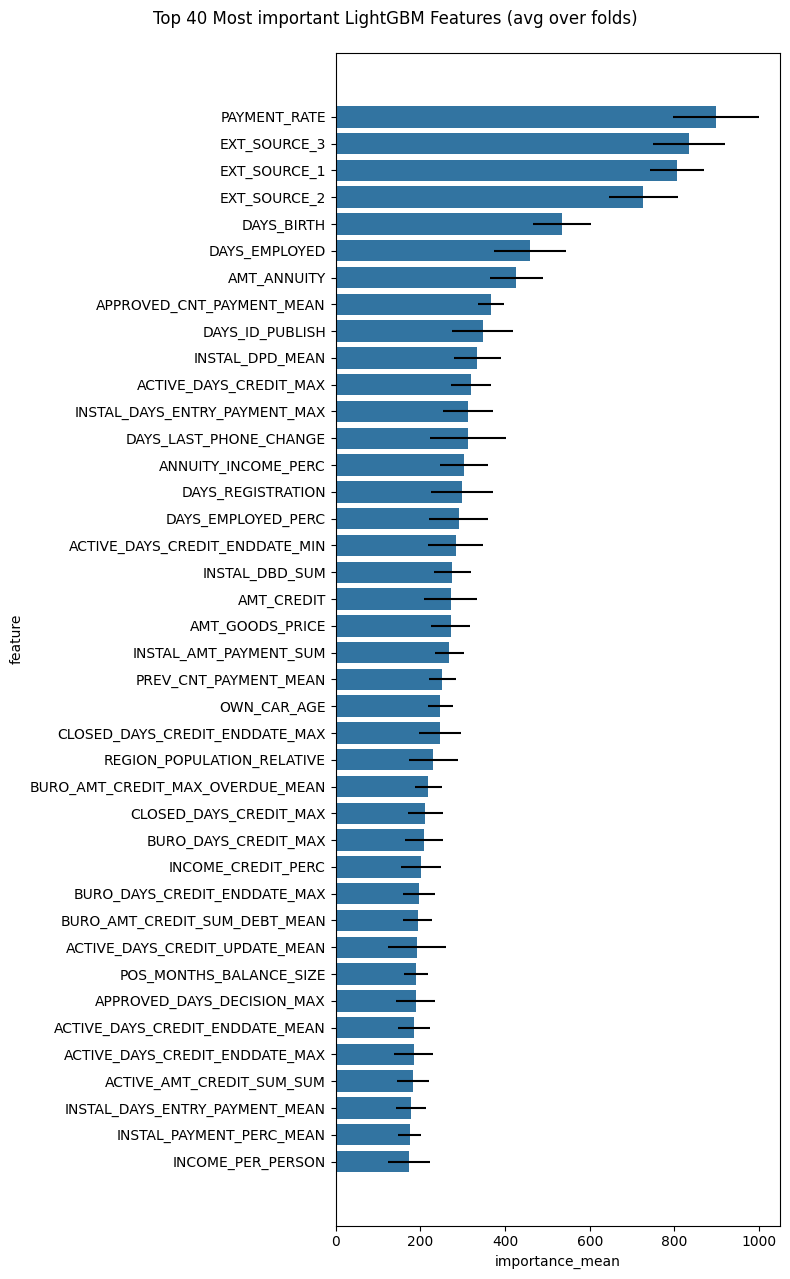

In [10]:
display_importances(feat_importance, sort_by_name=False, config=config)

In [ ]:
"""
df["DAYS_EMPLOYED_PERC"] = df["DAYS_EMPLOYED"] / df["DAYS_BIRTH"]
df["INCOME_CREDIT_PERC"] = df["AMT_INCOME_TOTAL"] / df["AMT_CREDIT"]
df["INCOME_PER_PERSON"] = df["AMT_INCOME_TOTAL"] / df["CNT_FAM_MEMBERS"]
df["ANNUITY_INCOME_PERC"] = df["AMT_ANNUITY"] / df["AMT_INCOME_TOTAL"]
df["PAYMENT_RATE"] = df["AMT_ANNUITY"] / df["AMT_CREDIT"]
"""

In [11]:
feat_importance.head(40)

,importance_mean,importance_std
feature,,
PAYMENT_RATE,897.9,101.380965
EXT_SOURCE_3,833.9,85.400299
EXT_SOURCE_1,805.8,63.756133
EXT_SOURCE_2,726.9,81.905705
DAYS_BIRTH,534.8,68.748818
DAYS_EMPLOYED,459.1,84.700059
AMT_ANNUITY,426.2,62.853975
APPROVED_CNT_PAYMENT_MEAN,366.4,30.869618
DAYS_ID_PUBLISH,347.6,71.771551


In [12]:
features_sorted_by_importance = feat_importance.index.tolist()
features_sorted_by_importance[:10]

['PAYMENT_RATE',
 'EXT_SOURCE_3',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'AMT_ANNUITY',
 'APPROVED_CNT_PAYMENT_MEAN',
 'DAYS_ID_PUBLISH',
 'INSTAL_DPD_MEAN']

In [13]:
feat_importance.to_csv(os.path.join(DATA_INTERIM, "importance.csv"))
joblib.dump(
    features_sorted_by_importance,
    os.path.join(DATA_INTERIM, "features_sorted_by_importance.pkl"),
)

['data/interim/features_sorted_by_importance.pkl']

Missing

In [14]:
df = pd.read_csv(
    os.path.join(DATA_INTERIM, "all_data_simple_kernel_ohe.csv"),
    usecols=important_features + ["TARGET"],
)
df.head()

NameError: name 'important_features' is not defined

In [81]:
train = df[df["TARGET"].notnull()]
train.shape

(307507, 41)

In [83]:
train_with_default = train[train["TARGET"] == 1]
train_with_default.shape

(24825, 41)

In [85]:
train_no_default = train[train["TARGET"] == 0]
train_no_default.shape

(282682, 41)

In [77]:
# from src.p7_missing_values import missing_values_barh

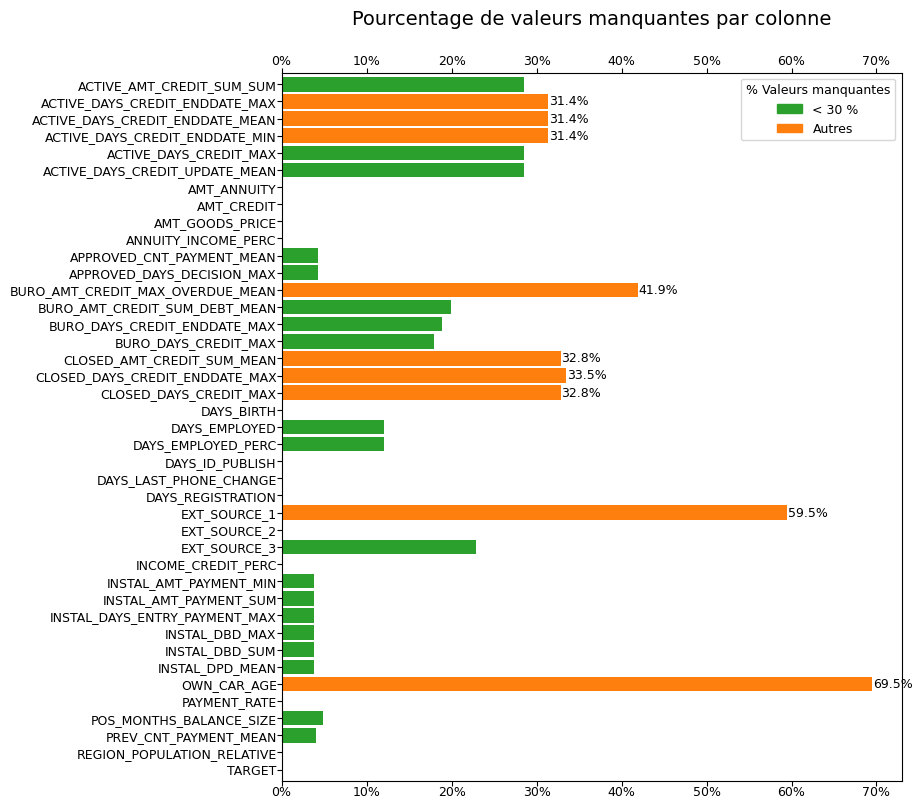

In [84]:
missing_columns, _, _ = missing_values_barh(train_with_default, sort="index")

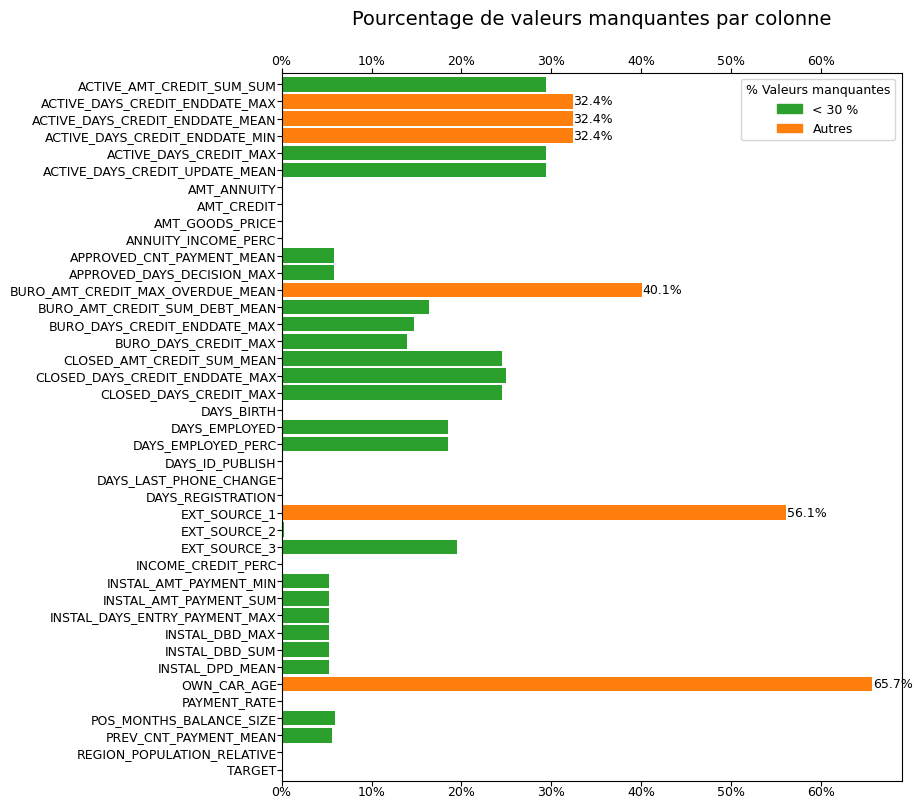

In [86]:
missing_columns, _, _ = missing_values_barh(train_no_default, sort="index")

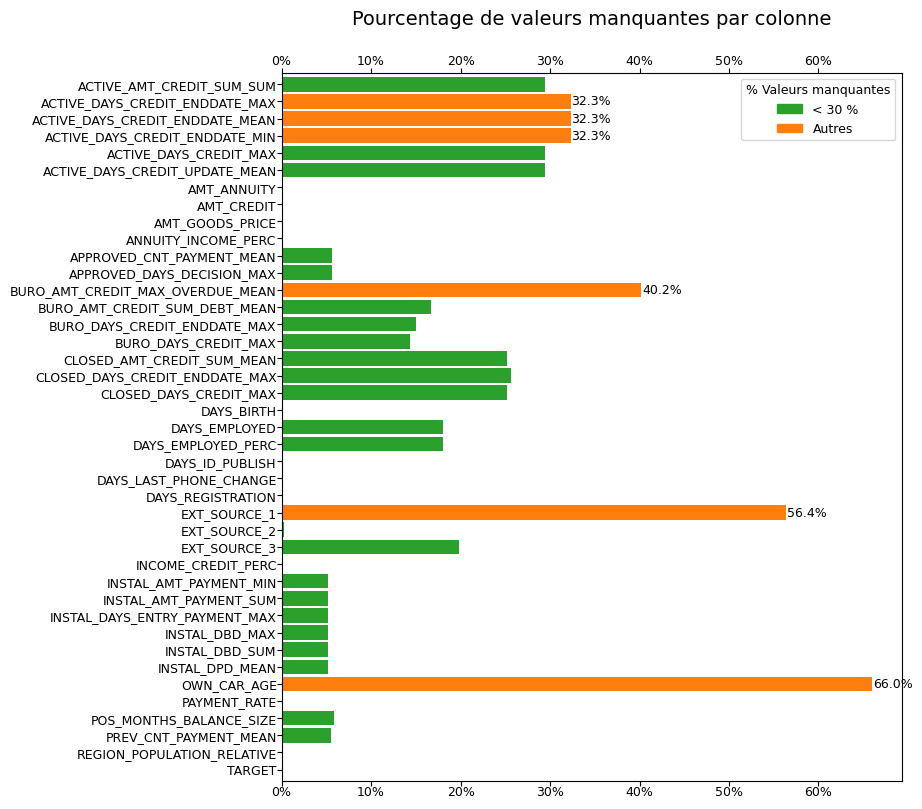

In [87]:
missing_columns, _, _ = missing_values_barh(train, sort="index")

In [88]:
to_drop = ["OWN_CAR_AGE", "EXT_SOURCE_1", "BUREAU_AMT_CREDIT_MAX_OVERDUE_MEAN"]

In [ ]:
"""
Idées pour EXT_SOURCE_1 : 
- essayer avec EXT_SOURCE_1 en booléen True si known (=non_missing), False si unknown (=missing)
- supprimer des lignes non_default où EXT_SOURCE_1 est missing jusqu'à arriver à 30% environ
"""

In [31]:
mean_importance = (
    feat_importance.drop("fold", axis=1)
    .groupby("feature")
    .agg(
        importance_mean=("importance", "mean"),
        importance_std=("importance", "std"),
    )
    .sort_values(by="importance_mean", ascending=False)
)
mean_importance

,importance_mean,importance_std
feature,,
EXT_SOURCE_2,176.7,14.166078
EXT_SOURCE_3,140.5,17.513487
EXT_SOURCE_1,87.5,17.180415
PAYMENT_RATE,82.2,21.451755
INSTAL_AMT_PAYMENT_MIN,50.9,11.666190
...,...,...
ORGANIZATION_TYPE_Tradetype6,0.0,0.000000
ORGANIZATION_TYPE_Tradetype5,0.0,0.000000
ORGANIZATION_TYPE_Tradetype4,0.0,0.000000


In [27]:
mean_importance = (
    feat_importance.drop("fold", axis=1)
    .groupby("feature")
    .mean()
    .sort_values(by="importance", ascending=False)
    .head(40)
)
mean_importance

,importance
feature,
EXT_SOURCE_2,176.7
EXT_SOURCE_3,140.5
EXT_SOURCE_1,87.5
PAYMENT_RATE,82.2
INSTAL_AMT_PAYMENT_MIN,50.9
APPROVED_CNT_PAYMENT_MEAN,45.4
PREV_NAME_YIELD_GROUP_high_MEAN,44.4
DAYS_ID_PUBLISH,43.7
INSTAL_DBD_MEAN,42.2


In [26]:
mean_importance.reset_index()

feature importance          
                                              mean       std
0                ACTIVE_AMT_ANNUITY_MAX        0.7  1.636392
1               ACTIVE_AMT_ANNUITY_MEAN        0.7  1.251666
2    ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN        2.2  2.658320
3        ACTIVE_AMT_CREDIT_SUM_DEBT_MAX        3.3  2.907844
4       ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN        6.1  3.665151
..                                  ...        ...       ...
775        YEARS_BEGINEXPLUATATION_MEDI        1.5  1.957890
776        YEARS_BEGINEXPLUATATION_MODE        3.5  2.415229
777                     YEARS_BUILD_AVG        0.1  0.316228
778                    YEARS_BUILD_MEDI        0.1  0.316228
779                    YEARS_BUILD_MODE        0.6  0.843274

[780 rows x 3 columns]

In [124]:
train[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].describe()

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3
count,134131.000000,3.068470e+05,246542.000000
mean,0.502129,5.143918e-01,0.510856
std,0.211063,1.910603e-01,0.194843
min,0.014568,8.173617e-08,0.000527
25%,0.334007,3.924574e-01,0.370650
50%,0.505998,5.659614e-01,0.535276
75%,0.675057,6.636171e-01,0.669057
max,0.962693,8.549997e-01,0.896010


# IDEM mais après correction NaN as Cat partout

Paramètre de configuration par défaut

In [74]:
print("Paramètres de configuration par défaut :")
config = CONFIG_SIMPLE
print(config)

Paramètres de configuration par défaut :
{'debug': False, 'nan_as_cat': True, 'data_output_dir': 'data/interim/', 'data_filename': 'all_data_simple_kernel_ohe.csv', 'generate_submission_files': False, 'model_dir': 'models/', 'model_subdir': 'light_simple/', 'importance_filename': 'feature_importance.csv', 'submission_filename': 'lightgbm_simple_submission.csv', 'num_threads': 16, 'stratified_kfold': True, 'num_folds': 10, 'early_stopping': 100, 'random_seed': 1001, 'inportance_filename': 'feature_importance_2.csv'}


In [75]:
config["debug"] = False
config["importance_filename"] = "feature_importance_01.csv"

In [76]:
print("Paramètres utilisés pour le LGBMClassifier :")
print(LIGHTGBM_PARAMS_SIMPLE)

Paramètres utilisés pour le LGBMClassifier :
{'n_estimators': 10000, 'learning_rate': 0.02, 'num_leaves': 34, 'colsample_bytree': 0.9497036, 'subsample': 0.8715623, 'max_depth': 8, 'reg_alpha': 0.041545473, 'reg_lambda': 0.0735294, 'min_split_gain': 0.0222415, 'min_child_weight': 39.3259775, 'silent': -1, 'verbose': -1}


In [78]:
with timer("Run LightGBM"):
    feat_importance = kfold_lightgbm_simple(df=None, config=config)

models/ dossier déjà existant
models/light_simple/ dossier déjà existant
Starting LightGBM. Train shape: (307507, 794), test shape: (48744, 794)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1302]	training's auc: 0.870892	training's binary_logloss: 0.2041	valid_1's auc: 0.786661	valid_1's binary_logloss: 0.23766
Fold  1 AUC : 0.786661
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1526]	training's auc: 0.879782	training's binary_logloss: 0.200066	valid_1's auc: 0.788728	valid_1's binary_logloss: 0.236557
Fold  2 AUC : 0.788728
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1143]	training's auc: 0.863183	training's binary_logloss: 0.20768	valid_1's auc: 0.791174	valid_1's binary_logloss: 0.235203
Fold  3 AUC : 0.791174
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1274]	training's auc

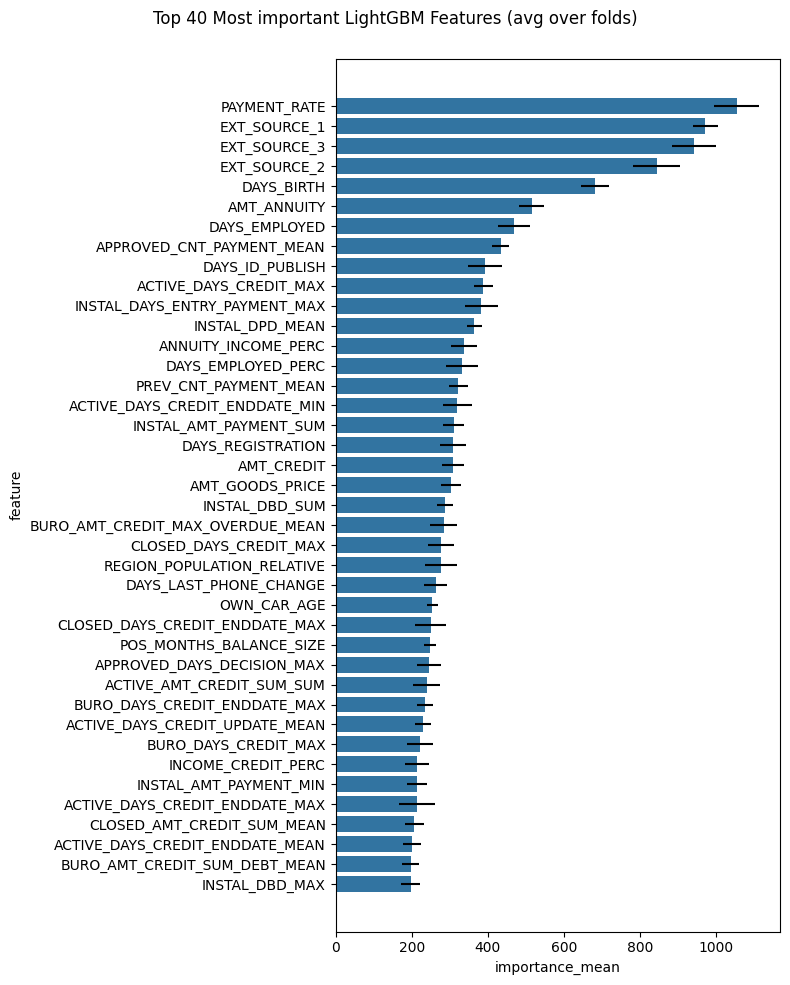

In [79]:
display_importances(feat_importance, config=config)

In [80]:
important_features = feat_importance.head(40).index.tolist()
important_features

['PAYMENT_RATE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_3',
 'EXT_SOURCE_2',
 'DAYS_BIRTH',
 'AMT_ANNUITY',
 'DAYS_EMPLOYED',
 'APPROVED_CNT_PAYMENT_MEAN',
 'DAYS_ID_PUBLISH',
 'ACTIVE_DAYS_CREDIT_MAX',
 'INSTAL_DAYS_ENTRY_PAYMENT_MAX',
 'INSTAL_DPD_MEAN',
 'ANNUITY_INCOME_PERC',
 'DAYS_EMPLOYED_PERC',
 'PREV_CNT_PAYMENT_MEAN',
 'ACTIVE_DAYS_CREDIT_ENDDATE_MIN',
 'INSTAL_AMT_PAYMENT_SUM',
 'DAYS_REGISTRATION',
 'AMT_CREDIT',
 'AMT_GOODS_PRICE',
 'INSTAL_DBD_SUM',
 'BURO_AMT_CREDIT_MAX_OVERDUE_MEAN',
 'CLOSED_DAYS_CREDIT_MAX',
 'REGION_POPULATION_RELATIVE',
 'DAYS_LAST_PHONE_CHANGE',
 'OWN_CAR_AGE',
 'CLOSED_DAYS_CREDIT_ENDDATE_MAX',
 'POS_MONTHS_BALANCE_SIZE',
 'APPROVED_DAYS_DECISION_MAX',
 'ACTIVE_AMT_CREDIT_SUM_SUM',
 'BURO_DAYS_CREDIT_ENDDATE_MAX',
 'ACTIVE_DAYS_CREDIT_UPDATE_MEAN',
 'BURO_DAYS_CREDIT_MAX',
 'INCOME_CREDIT_PERC',
 'INSTAL_AMT_PAYMENT_MIN',
 'ACTIVE_DAYS_CREDIT_ENDDATE_MAX',
 'CLOSED_AMT_CREDIT_SUM_MEAN',
 'ACTIVE_DAYS_CREDIT_ENDDATE_MEAN',
 'BURO_AMT_CREDIT_SUM_DEBT_MEAN',


In [82]:
joblib.dump(
    important_features,
    os.path.join(
        config["model_dir"] + config["model_subdir"], "important_features_01.pkl"
    ),
)

['models/light_simple/important_features_01.pkl']

In [ ]:
feat_importance.to_csv(
    os.path.join(
        config["model_dir"] + config["model_subdir"],
        "feature_importance_simple_kernel.csv",
    )
)

# Essai avec EXT_SOURCE_1_ZERO et EXT_SOURCE_1_known à la place de EXT_SOURCE_1 - pas de réquilibrage

In [4]:
df = pd.read_csv(os.path.join(DATA_INTERIM, "all_data_simple_kernel_ohe.csv"))

In [5]:
df["EXT_SOURCE_1_KNOWN"] = df["EXT_SOURCE_1"].apply(
    lambda x: False if np.isnan(x) else True
)
df["EXT_SOURCE_1_KNOWN"].value_counts()

EXT_SOURCE_1_KNOWN
False    193908
True     162343
Name: count, dtype: int64

In [6]:
df["EXT_SOURCE_1_ZERO"] = df["EXT_SOURCE_1"].apply(lambda x: 0 if np.isnan(x) else x)

In [7]:
df = df.drop("EXT_SOURCE_1", axis=1)

In [ ]:
# On enlève OWN_CAR_AGE ? ou on le met à une valeur très grande ?

In [8]:
print("Paramètres de configuration par défaut :")
config = CONFIG_SIMPLE
print(config)

Paramètres de configuration par défaut :
{'debug': False, 'nan_as_cat': True, 'data_output_dir': 'data/interim/', 'data_filename': 'all_data_simple_kernel_ohe.csv', 'generate_submission_files': True, 'model_dir': 'models/', 'model_subdir': 'light_simple/', 'importance_filename': 'feature_importance.csv', 'submission_filename': 'lightgbm_simple_submission.csv', 'num_threads': 16, 'stratified_kfold': True, 'num_folds': 10, 'early_stopping': 100, 'random_seed': 1001}


In [9]:
config["debug"] = False
config["inportance_filename"] = "feature_importance_2.csv"
config["generate_submission_files"] = False

In [16]:
with timer("Run LightGBM"):
    feat_importance_2 = kfold_lightgbm_simple(df=df, config=config)
    print(feat_importance_2)

models/ dossier déjà existant
models/light_simple/ dossier déjà existant
Starting LightGBM. Train shape: (307507, 795), test shape: (48744, 795)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1315]	training's auc: 0.872012	training's binary_logloss: 0.203707	valid_1's auc: 0.78633	valid_1's binary_logloss: 0.237799
Fold  1 AUC : 0.786330
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1078]	training's auc: 0.860537	training's binary_logloss: 0.208884	valid_1's auc: 0.787517	valid_1's binary_logloss: 0.236734
Fold  2 AUC : 0.787517
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1506]	training's auc: 0.879125	training's binary_logloss: 0.20055	valid_1's auc: 0.792194	valid_1's binary_logloss: 0.234765
Fold  3 AUC : 0.792194
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2102]	training's a

In [14]:
from src.p7_simple_kernel import display_importances

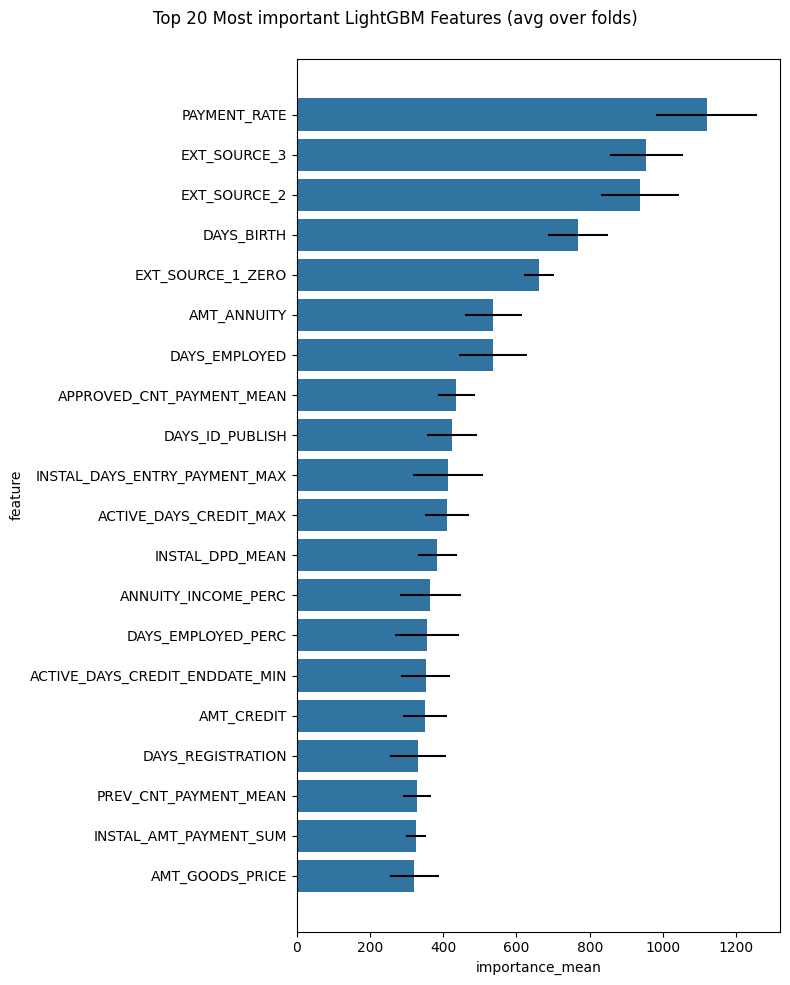

In [18]:
display_importances(feat_importance_2, sort_by_name=False, top=20, config=config)

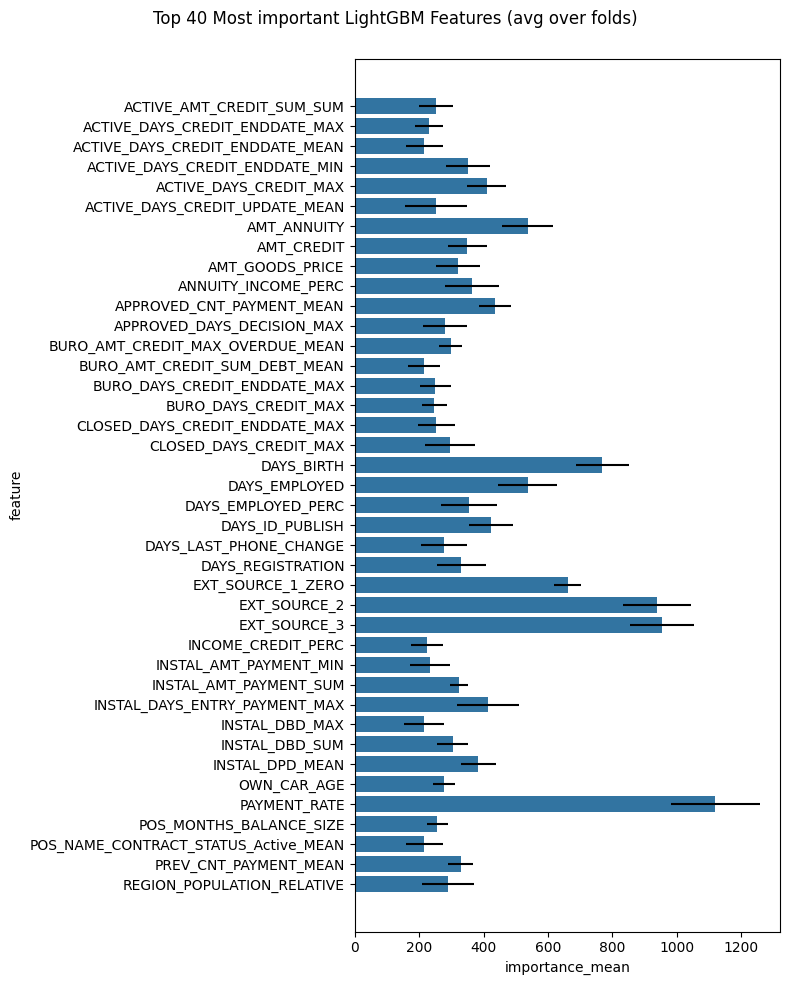

In [17]:
display_importances(feat_importance_2, sort_by_name=True, config=config)

In [ ]:
# Ou on enlève les features qui ont le même nom mais se terminent par MIN / MAX / MEAN mais qui ont une moindre importance,
# ou on fait une matrice des corrélations triée. (Uniuquement sur le train et avec la target)
# ou l'algo Mici
to_drop = [
    "ACTIVE_DAYS_CREDIT_ENDDATE_MAX",
    "ACTIVE_DAYS_CREDIT_ENDDATE_MEAN",
    "INSTAL_AMT_PAYMENT_MIN",
    "INSTAL_DBD_MAX",
    #'INSTAL_DBD_SUM',
]

Matrice corrélations sur les 40 premières features

In [19]:
from src.p7_explore import corr_sorted_map

In [33]:
important_features = feat_importance_2.head(30).index.tolist()
important_features

['PAYMENT_RATE',
 'EXT_SOURCE_3',
 'EXT_SOURCE_2',
 'DAYS_BIRTH',
 'EXT_SOURCE_1_ZERO',
 'AMT_ANNUITY',
 'DAYS_EMPLOYED',
 'APPROVED_CNT_PAYMENT_MEAN',
 'DAYS_ID_PUBLISH',
 'INSTAL_DAYS_ENTRY_PAYMENT_MAX',
 'ACTIVE_DAYS_CREDIT_MAX',
 'INSTAL_DPD_MEAN',
 'ANNUITY_INCOME_PERC',
 'DAYS_EMPLOYED_PERC',
 'ACTIVE_DAYS_CREDIT_ENDDATE_MIN',
 'AMT_CREDIT',
 'DAYS_REGISTRATION',
 'PREV_CNT_PAYMENT_MEAN',
 'INSTAL_AMT_PAYMENT_SUM',
 'AMT_GOODS_PRICE',
 'INSTAL_DBD_SUM',
 'BURO_AMT_CREDIT_MAX_OVERDUE_MEAN',
 'CLOSED_DAYS_CREDIT_MAX',
 'REGION_POPULATION_RELATIVE',
 'APPROVED_DAYS_DECISION_MAX',
 'DAYS_LAST_PHONE_CHANGE',
 'OWN_CAR_AGE',
 'POS_MONTHS_BALANCE_SIZE',
 'ACTIVE_AMT_CREDIT_SUM_SUM',
 'CLOSED_DAYS_CREDIT_ENDDATE_MAX']

In [39]:
# On retire 'OWN_CAR_AGE' car trop de manquant
important_features.remove("OWN_CAR_AGE")

In [52]:
from sklearn.discriminant_analysis import StandardScaler


data = df[important_features + ["TARGET"]]
data = data[data["TARGET"].notnull()]
scaler = StandardScaler()
data = pd.DataFrame(
    scaler.fit_transform(data[important_features]), columns=important_features
)

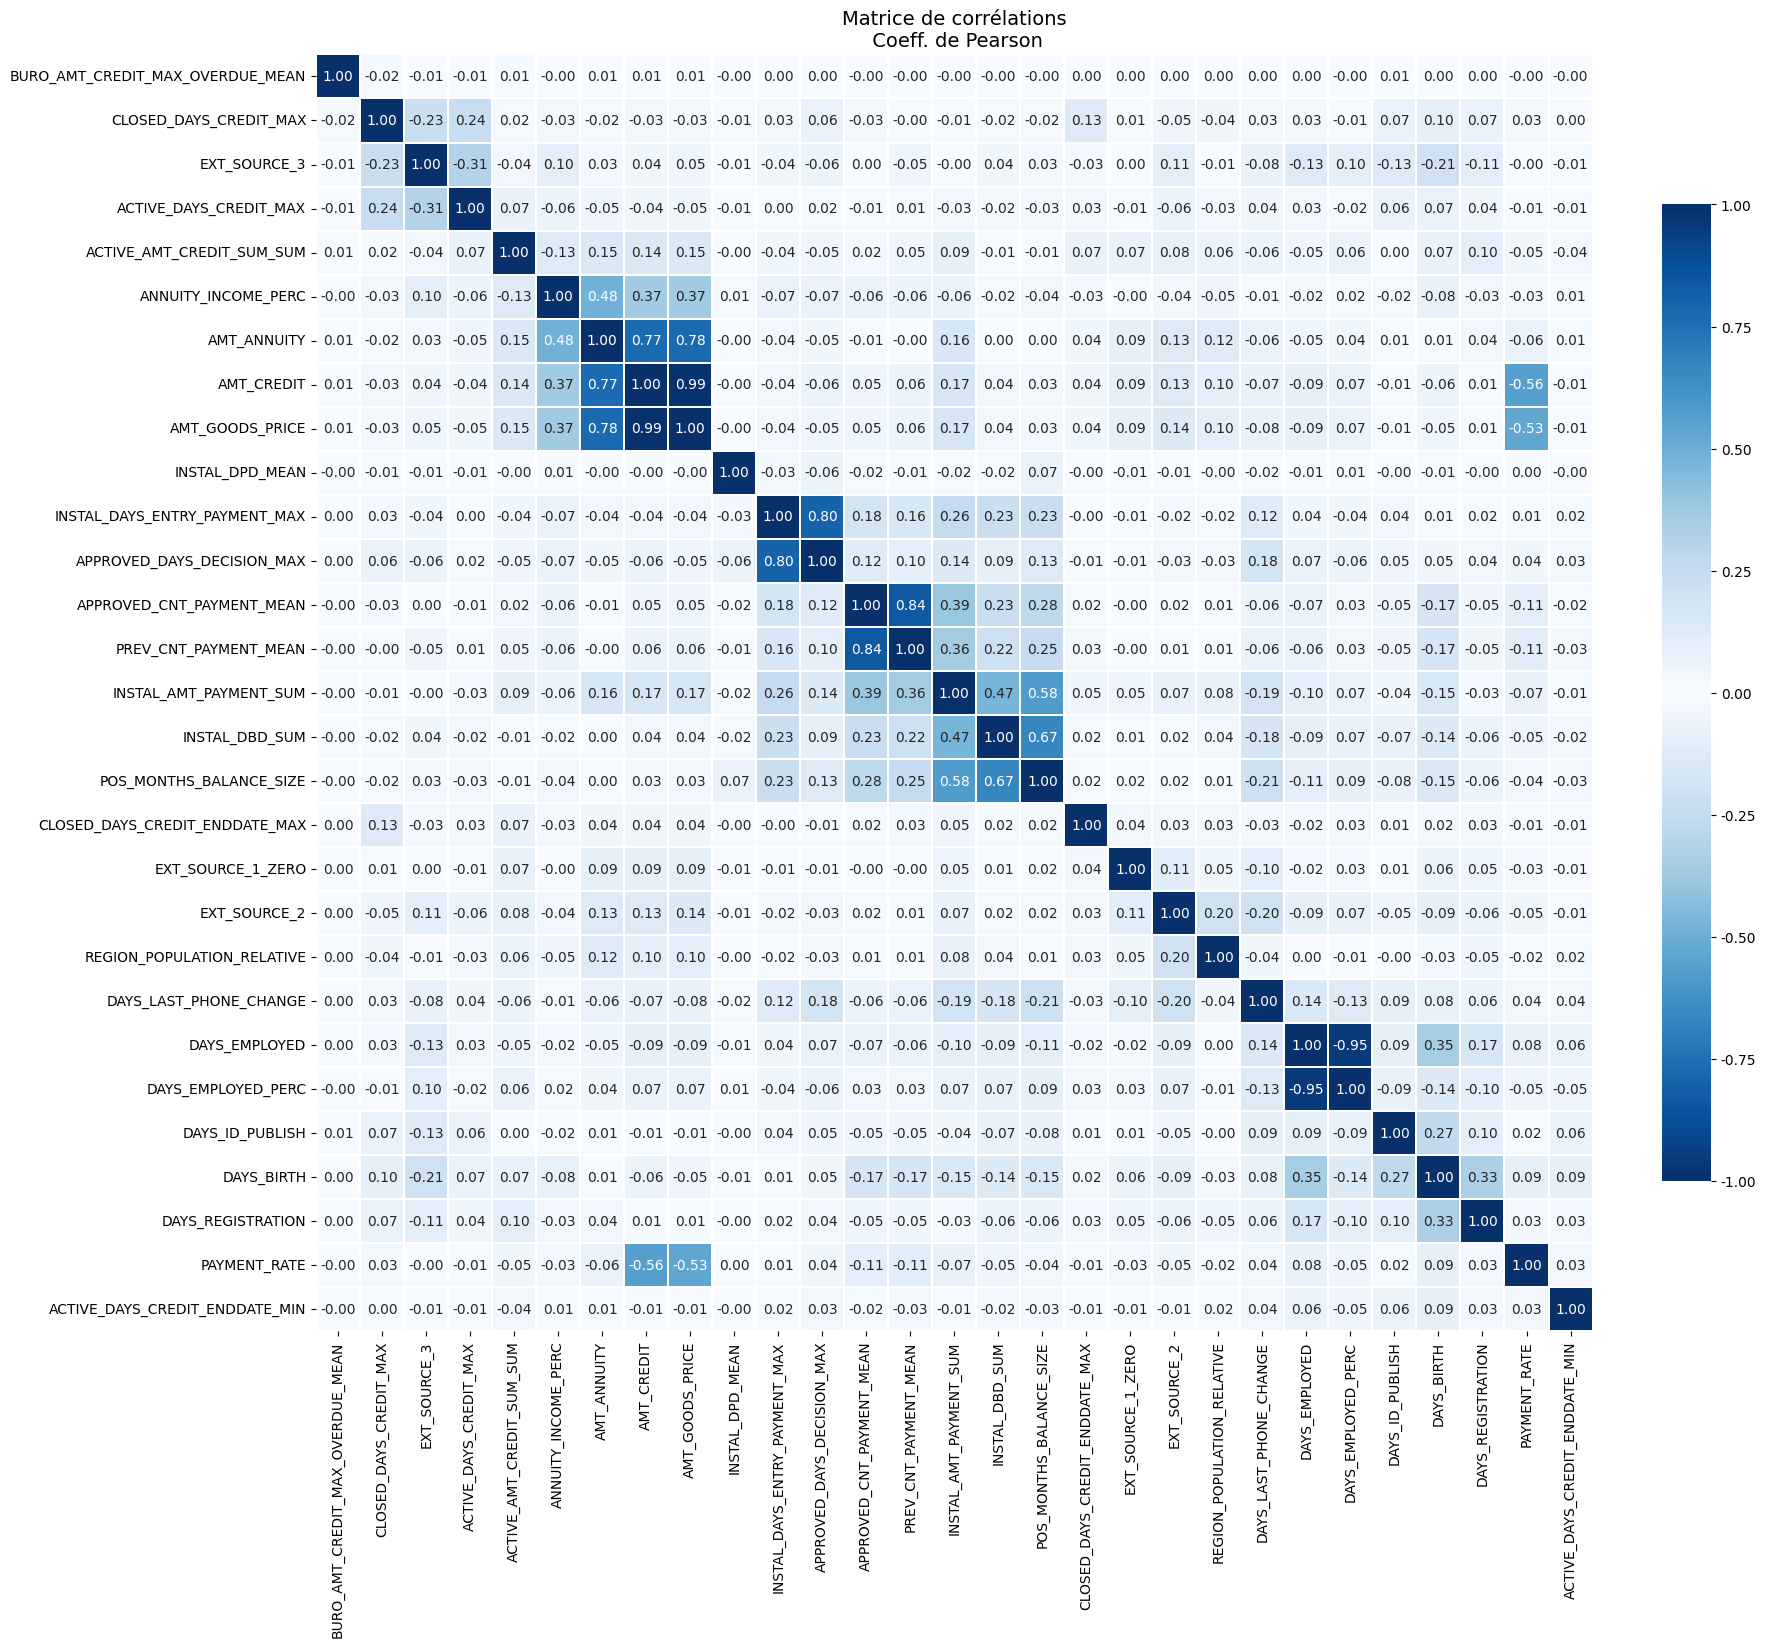

In [53]:
# _ = corr_sorted_map(data, to_process=important_features + ['TARGET'], to_mark=['TARGET'], method='pearson', figsize=(18, 18))
_ = corr_sorted_map(
    data, to_process=important_features, method="pearson", figsize=(18, 18)
)

In [ ]:
"""
Entre AMT_CREDIT et AMT_GOODS_PRICE, on choisit AMT_CREDIT qui a une plus grande importance
Sauf que la différence réside peut-être dans ceux qui ont fait défaut ou pas.
Il faudrait faire une boxplot sur la différence AMT_CREDIT et AMT_GOODS_PRICE pour les défauts et les non_defauts. Ou un ETA_MAP

Entre DAYS_EMPLOYED et DAYS_EMPLOYED_PERC on choisit DAYS_EMPLOYED
"""

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
train = df[df["TARGET"].notnull()]
train["DIFF_AMT_CREDIT_GOODS"] = train["AMT_GOODS_PRICE"] - train["AMT_CREDIT"]

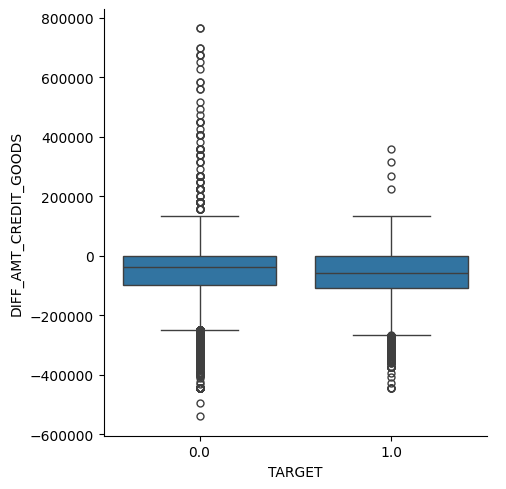

In [62]:
# Ceux qui ont fait défaut on tendance à emprunter plus que le prix des biens (encore plus que les autres)
# plus d'intérêt et/ou  moins d'apport initial
sns.catplot(
    train[["DIFF_AMT_CREDIT_GOODS", "TARGET"]],
    x="TARGET",
    y="DIFF_AMT_CREDIT_GOODS",
    kind="box",
)

In [64]:
from src.p7_explore import bivariate_anova_non_param

In [66]:
bivariate_anova_non_param(
    train[["DIFF_AMT_CREDIT_GOODS", "TARGET"]], x="TARGET", y="DIFF_AMT_CREDIT_GOODS"
)


Test de Kruskal-Wallis (DIFF_AMT_CREDIT_GOODS par modalités de TARGET)
H0 : Toutes les médianes sont égales


,Source,ddof1,H,p-unc
Kruskal,TARGET,1,556.075873,6.001418e-123


Welch ANOVA (DIFF_AMT_CREDIT_GOODS par modalités de TARGET)


,Source,ddof1,ddof2,F,p-unc,np2
0,TARGET,1,29440.066586,367.852769,1.727145e-81,0.001173


Tests post-hoc Games-Howell (DIFF_AMT_CREDIT_GOODS par modalités de TARGET)


,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,0.0,1.0,-60204.362,-69066.994,8862.632,462.089,19.179,29440.067,0.0,0.126


In [ ]:
"""
Il y aurait bien une différence significative entre les médianes selon Défaut / Non Défaut

En pratique, des tailles d'échantillon inégales peuvent conduire à une perte de puissance statistique, 
ce qui signifie que le test peut être moins sensible pour détecter les différences entre les groupes 
lorsque les tailles d'échantillon varient considérablement
"""

# Essai en enlevant des ligne de EXT_SOURCE_1 à NaN,  puis en réquilibrant avec SMOTE

In [137]:
# On se base les plus importantes features obtenues en 01
important_features = joblib.load("models/light_simple/important_features_01.pkl")
if "OWN_CAR_AGE" in important_features:
    important_features.remove("OWN_CAR_AGE")

In [68]:
df = pd.read_csv(os.path.join(DATA_INTERIM, "all_data_simple_kernel_ohe.csv"))
df.head(1)

,Unnamed: 0,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CC_NAME_CONTRACT_STATUS_Sent proposal_MEAN,CC_NAME_CONTRACT_STATUS_Sent proposal_SUM,CC_NAME_CONTRACT_STATUS_Sent proposal_VAR,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Calcul du nombre de lignes à éliminer pour tomber à 30% de NaN

In [149]:
from sklearn.utils import shuffle

In [150]:
train_important = df.loc[
    df["TARGET"].notnull(), ["SK_ID_CURR", "TARGET"] + important_features
].set_index("SK_ID_CURR")

n_rows = train.shape[0]
n_rows

307507

In [220]:
n_missing_1 = train_important["EXT_SOURCE_1"].isnull().sum(axis=0)
ratio_1 = n_missing_1 / n_rows
print(f"Actuellement, il y a {n_missing_1} valeurs manquantes (ratio = {ratio_1:.0%})")
ratio_2 = 0.3
# ratio_2 = n_missing_2 / (n_rows - n_rows_to_del)
# ratio_2 * (n_rows - n_row_to_del) = n_missing_2
# ratio_2 * (n_rows - n_missing_1 + n_missing_2) = n_missing_2
# ratio_2 * (n_rows - n_missing_1) = n_missing_2 * (1 - ratio_2)
# n_missing_2 = ratio_2 * (n_rows - n_missing_1) / (1 - ratio_2)
n_missing_2 = round(ratio_2 * (n_rows - n_missing_1) / (1 - ratio_2))
print(
    f"Pour tomber à {ratio_2:.0%} de valeurs manquantes, il nous faudrait {round(n_missing_2)} valeurs manquantes"
)
n_rows_to_del = n_missing_1 - n_missing_2
print(f"Il nous faut donc supprimer {n_rows_to_del} lignes")

Actuellement, il y a 173376 valeurs manquantes (ratio = 56%)
Pour tomber à 30% de valeurs manquantes, il nous faudrait 57485 valeurs manquantes
Il nous faut donc supprimer 115891 lignes


Sélection des lignes à supprimier

In [221]:
# On sélectionne un sous ensemble : train et pas de défaut

train_no_default = df.loc[
    df["TARGET"] == 0, ["SK_ID_CURR", "TARGET"] + important_features
]
train_no_default = shuffle(train_no_default, random_state=42)
train_no_default.head()

,SK_ID_CURR,TARGET,PAYMENT_RATE,EXT_SOURCE_1,EXT_SOURCE_3,EXT_SOURCE_2,DAYS_BIRTH,AMT_ANNUITY,DAYS_EMPLOYED,APPROVED_CNT_PAYMENT_MEAN,...,BURO_DAYS_CREDIT_ENDDATE_MAX,ACTIVE_DAYS_CREDIT_UPDATE_MEAN,BURO_DAYS_CREDIT_MAX,INCOME_CREDIT_PERC,INSTAL_AMT_PAYMENT_MIN,ACTIVE_DAYS_CREDIT_ENDDATE_MAX,CLOSED_AMT_CREDIT_SUM_MEAN,ACTIVE_DAYS_CREDIT_ENDDATE_MEAN,BURO_AMT_CREDIT_SUM_DEBT_MEAN,INSTAL_DBD_MAX
150486,274455,0.0,0.050000,0.655019,0.200926,0.673593,-15318,13500.0,-564.0,36.000000,...,2124.0,-23.6,-280.0,0.750000,47071.215,2124.0,180225.00,1091.5,295860.0,27.0
136656,258502,0.0,0.029356,NaN,0.652897,0.376551,-10341,33025.5,-1390.0,8.000000,...,268.0,-17.0,-827.0,0.140000,2.160,NaN,310704.75,NaN,0.0,35.0
136808,258682,0.0,0.039775,0.615455,0.707699,0.648879,-19278,44302.5,-8570.0,12.666667,...,31121.0,-92.5,-233.0,0.121202,3.150,31121.0,147225.00,31121.0,0.0,109.0
18793,121915,0.0,0.070319,NaN,0.713631,0.511677,-14666,12510.0,-3974.0,8.666667,...,-1086.0,NaN,-1360.0,0.531188,3168.135,NaN,157135.50,NaN,0.0,23.0
188846,318940,0.0,0.042485,NaN,0.598926,0.541922,-11561,46764.0,-3750.0,6.000000,...,13.0,-33.0,-110.0,0.081765,19070.100,13.0,118593.00,13.0,9864.0,14.0


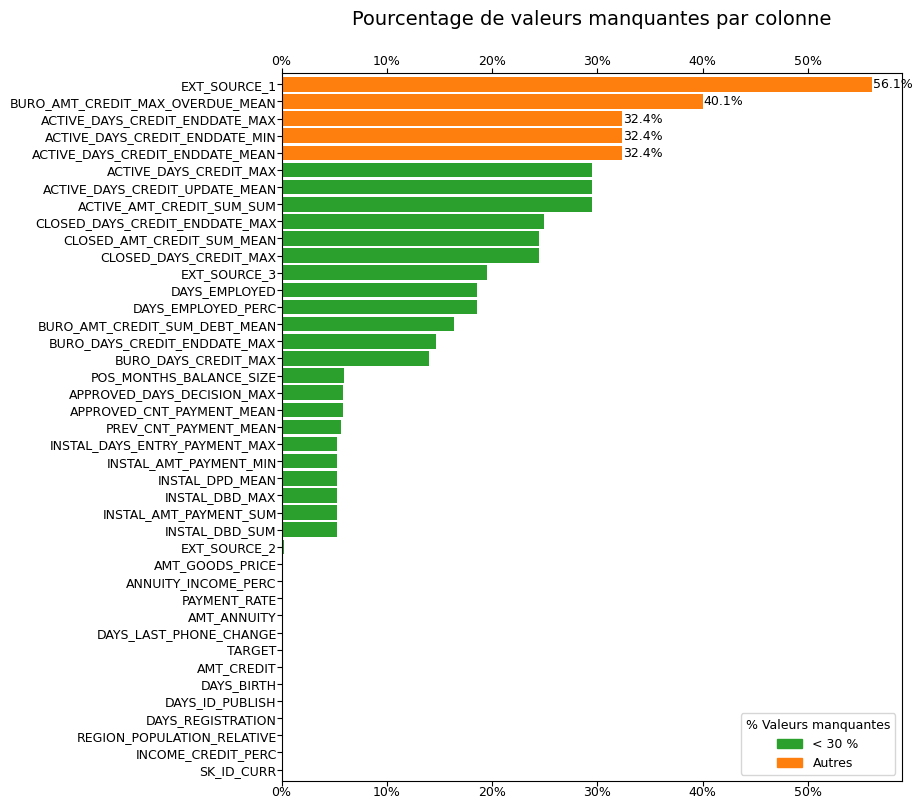

In [222]:
_ = missing_values_barh(train_no_default)

In [223]:
# On sélectionne les EXT_SOURCE_1 NaN car on veut éliminer des lignes uniquement pour ces NaN
subset = train_no_default.loc[train_no_default["EXT_SOURCE_1"].isnull(), :]

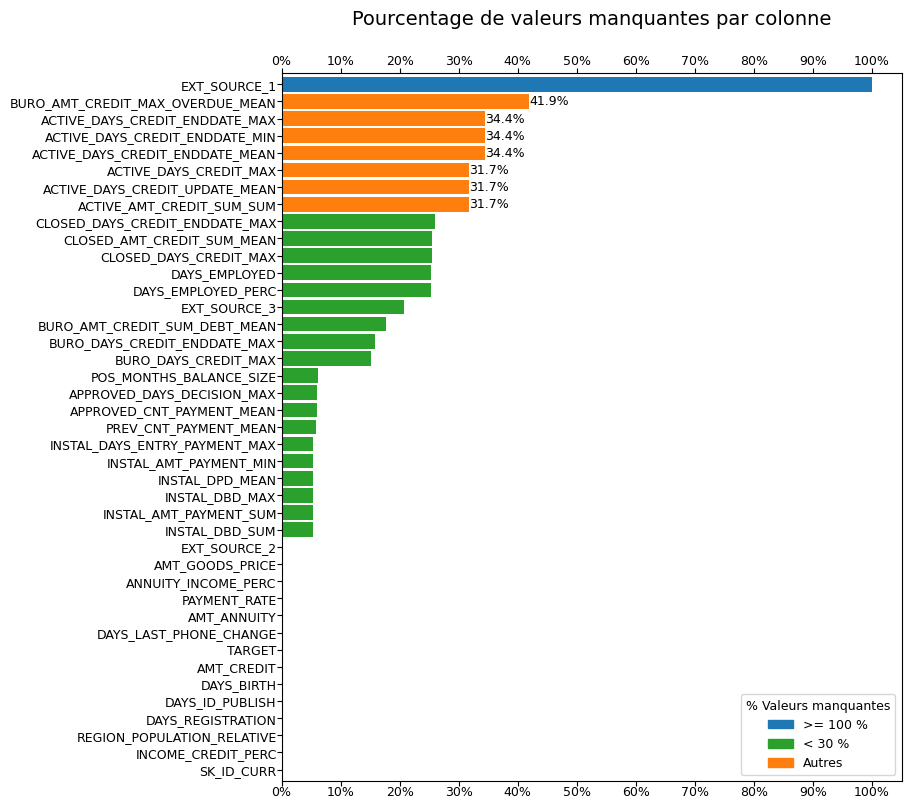

In [224]:
_ = missing_values_barh(subset)

In [225]:
# On élimine les lignes qui ont le moins de valeurs manquantes sur toutes les features
# On calcule le nombre de valeurs manquantes par ligne
subset.loc[:, "n_missing"] = subset.isnull().sum(axis=1)
subset.head()

D:\TEMP\ipykernel_14632\3267382584.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset.loc[:, 'n_missing'] = subset.isnull().sum(axis=1)


,SK_ID_CURR,TARGET,PAYMENT_RATE,EXT_SOURCE_1,EXT_SOURCE_3,EXT_SOURCE_2,DAYS_BIRTH,AMT_ANNUITY,DAYS_EMPLOYED,APPROVED_CNT_PAYMENT_MEAN,...,ACTIVE_DAYS_CREDIT_UPDATE_MEAN,BURO_DAYS_CREDIT_MAX,INCOME_CREDIT_PERC,INSTAL_AMT_PAYMENT_MIN,ACTIVE_DAYS_CREDIT_ENDDATE_MAX,CLOSED_AMT_CREDIT_SUM_MEAN,ACTIVE_DAYS_CREDIT_ENDDATE_MEAN,BURO_AMT_CREDIT_SUM_DEBT_MEAN,INSTAL_DBD_MAX,n_missing
136656,258502,0.0,0.029356,NaN,0.652897,0.376551,-10341,33025.5,-1390.0,8.000000,...,-17.0,-827.0,0.140000,2.160,NaN,310704.75,NaN,0.0,35.0,4
18793,121915,0.0,0.070319,NaN,0.713631,0.511677,-14666,12510.0,-3974.0,8.666667,...,NaN,-1360.0,0.531188,3168.135,NaN,157135.50,NaN,0.0,23.0,8
188846,318940,0.0,0.042485,NaN,0.598926,0.541922,-11561,46764.0,-3750.0,6.000000,...,-33.0,-110.0,0.081765,19070.100,13.0,118593.00,13.000000,9864.0,14.0,1
303788,451978,0.0,0.038332,NaN,0.672243,0.333921,-11537,20263.5,-587.0,NaN,...,-802.0,-1206.0,0.212813,NaN,NaN,1787085.00,NaN,0.0,NaN,15
137044,258947,0.0,0.030620,NaN,0.262249,0.680193,-21475,20668.5,NaN,13.428571,...,-316.0,-54.0,0.133333,36.990,1547.0,234229.50,639.333333,485203.5,58.0,3


In [226]:
# On trie par nombre de missing
subset = subset.sort_values(by="n_missing", ascending=False)

In [227]:
# On sélectionne les ID de la moitié supérieure
id_to_del = subset["SK_ID_CURR"].head(n_rows_to_del).values.tolist()
id_to_del[:10]

[202201,
 307487,
 349198,
 341336,
 292743,
 424432,
 412312,
 244242,
 431333,
 281828]

In [232]:
# On supprime ces lignes du train
train = df.loc[df["TARGET"].notnull()].set_index("SK_ID_CURR")
train = train.drop(id_to_del)
train.shape

(191616, 794)

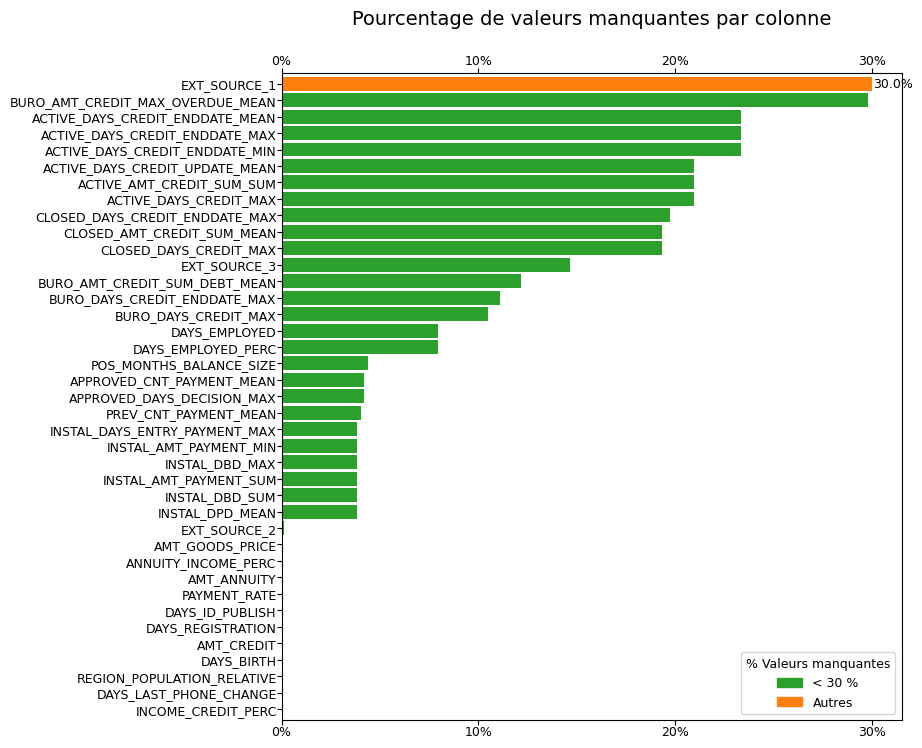

In [233]:
_ = missing_values_barh(train[important_features])

In [238]:
train = train.reset_index()

In [237]:
train.to_csv(os.path.join(DATA_INTERIM, "train_simple_reduced_03.csv"))

Feature importance

In [239]:
test = df[df["TARGET"].isnull()]
test.shape

(48744, 795)

In [240]:
df = pd.concat([train, test], axis=0)
df.shape

(240360, 795)

In [241]:
print("Paramètres de configuration par défaut :")
config = CONFIG_SIMPLE
print(config)

Paramètres de configuration par défaut :
{'debug': False, 'nan_as_cat': True, 'data_output_dir': 'data/interim/', 'data_filename': 'all_data_simple_kernel_ohe.csv', 'generate_submission_files': False, 'model_dir': 'models/', 'model_subdir': 'light_simple/', 'importance_filename': 'feature_importance_01.csv', 'submission_filename': 'lightgbm_simple_submission.csv', 'num_threads': 16, 'stratified_kfold': True, 'num_folds': 10, 'early_stopping': 100, 'random_seed': 1001, 'inportance_filename': 'feature_importance_2.csv'}


In [242]:
config["debug"] = False
config["importance_filename"] = "feature_importance_03.csv"

In [243]:
with timer("Run LightGBM"):
    feat_importance = kfold_lightgbm_simple(df=df, config=config)

models/ dossier déjà existant
models/light_simple/ dossier déjà existant
Starting LightGBM. Train shape: (191616, 794), test shape: (48744, 794)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1199]	training's auc: 0.933132	training's binary_logloss: 0.190009	valid_1's auc: 0.865706	valid_1's binary_logloss: 0.234856
Fold  1 AUC : 0.865706
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1367]	training's auc: 0.939179	training's binary_logloss: 0.185381	valid_1's auc: 0.867983	valid_1's binary_logloss: 0.231816
Fold  2 AUC : 0.867983
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1115]	training's auc: 0.930058	training's binary_logloss: 0.192262	valid_1's auc: 0.871357	valid_1's binary_logloss: 0.231712
Fold  3 AUC : 0.871357
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1112]	training's

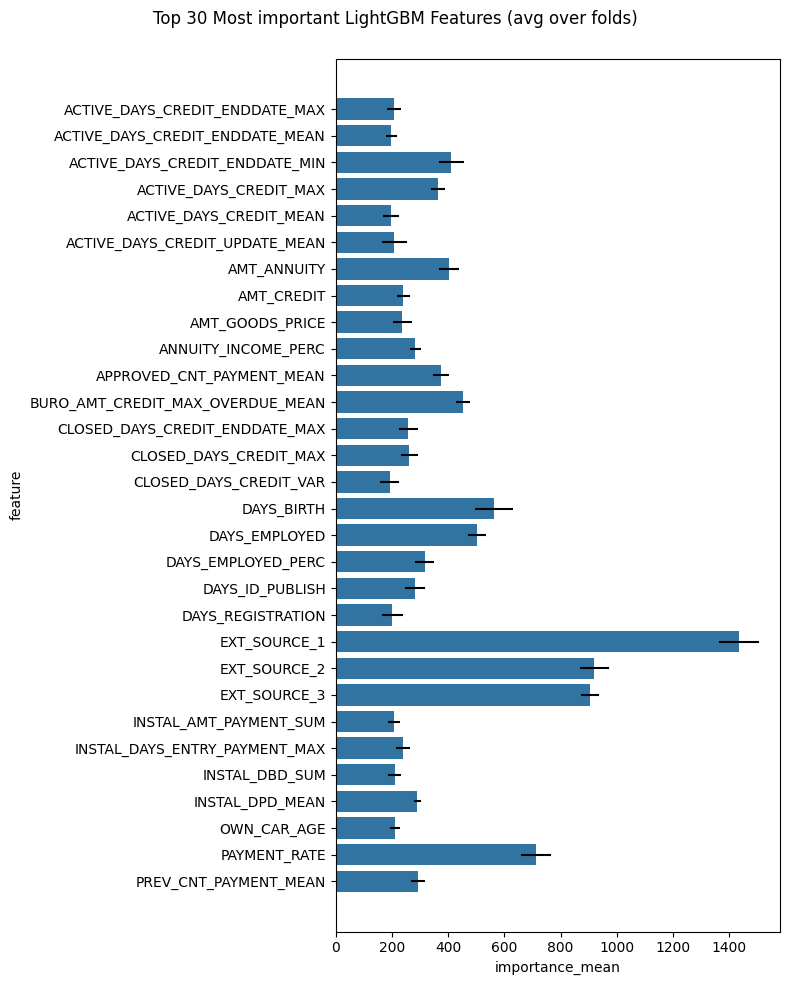

In [255]:
display_importances(feat_importance, sort_by_name=True, top=30, config=config)

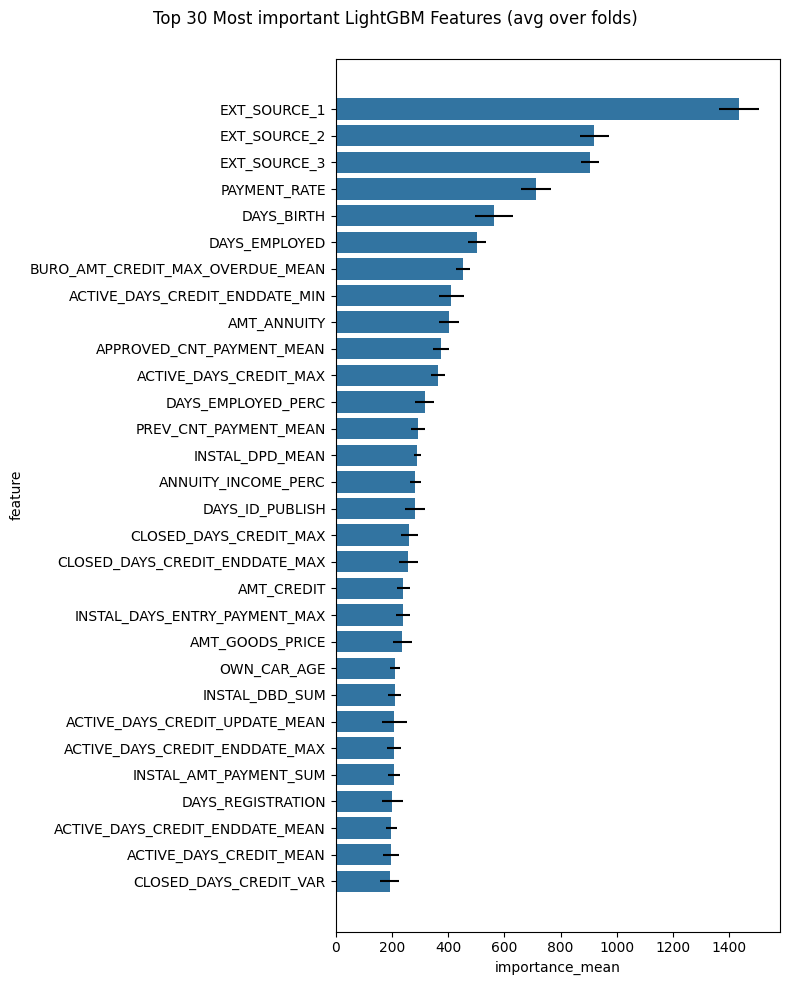

In [256]:
display_importances(feat_importance, top=30, config=config)

In [257]:
important_features = feat_importance.head(30).index.tolist()
important_features

['EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'PAYMENT_RATE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'BURO_AMT_CREDIT_MAX_OVERDUE_MEAN',
 'ACTIVE_DAYS_CREDIT_ENDDATE_MIN',
 'AMT_ANNUITY',
 'APPROVED_CNT_PAYMENT_MEAN',
 'ACTIVE_DAYS_CREDIT_MAX',
 'DAYS_EMPLOYED_PERC',
 'PREV_CNT_PAYMENT_MEAN',
 'INSTAL_DPD_MEAN',
 'ANNUITY_INCOME_PERC',
 'DAYS_ID_PUBLISH',
 'CLOSED_DAYS_CREDIT_MAX',
 'CLOSED_DAYS_CREDIT_ENDDATE_MAX',
 'AMT_CREDIT',
 'INSTAL_DAYS_ENTRY_PAYMENT_MAX',
 'AMT_GOODS_PRICE',
 'OWN_CAR_AGE',
 'INSTAL_DBD_SUM',
 'ACTIVE_DAYS_CREDIT_UPDATE_MEAN',
 'ACTIVE_DAYS_CREDIT_ENDDATE_MAX',
 'INSTAL_AMT_PAYMENT_SUM',
 'DAYS_REGISTRATION',
 'ACTIVE_DAYS_CREDIT_ENDDATE_MEAN',
 'ACTIVE_DAYS_CREDIT_MEAN',
 'CLOSED_DAYS_CREDIT_VAR']

In [258]:
joblib.dump(
    important_features,
    os.path.join(
        config["model_dir"] + config["model_subdir"], "important_features_03.pkl"
    ),
)

['models/light_simple/important_features_03.pkl']

Valeurs manquantes

In [259]:
train = pd.read_csv(
    os.path.join(DATA_INTERIM, "train_simple_reduced_03.csv"),
    usecols=["SK_ID_CURR", "TARGET"] + important_features,
)
train.head()

,SK_ID_CURR,TARGET,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,...,ACTIVE_DAYS_CREDIT_UPDATE_MEAN,CLOSED_DAYS_CREDIT_MAX,CLOSED_DAYS_CREDIT_VAR,CLOSED_DAYS_CREDIT_ENDDATE_MAX,PREV_CNT_PAYMENT_MEAN,APPROVED_CNT_PAYMENT_MEAN,INSTAL_DPD_MEAN,INSTAL_DBD_SUM,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX
0,100002,1.0,406597.5,24700.5,351000.0,-9461,-637.0,-3648.0,-2120,NaN,...,-15.50,-476.0,123956.700000,85.0,24.0,24.0,0.000000,388.0,219625.695,-49.0
1,100003,0.0,1293502.5,35698.5,1129500.0,-16765,-1188.0,-1186.0,-291,NaN,...,-43.00,-775.0,820590.333333,-420.0,10.0,10.0,0.000000,179.0,1618864.650,-544.0
2,100008,0.0,490495.5,27517.5,454500.0,-16941,-1588.0,-4970.0,-477,NaN,...,-16.00,-1097.0,0.000000,-792.0,14.0,14.0,37.628571,403.0,957617.595,-82.0
3,100009,0.0,1560726.0,41301.0,1395000.0,-13778,-3130.0,-1213.0,-619,17.0,...,-245.75,-684.0,343954.373626,1044.0,8.0,8.0,0.137255,445.0,487995.120,-58.0
4,100011,0.0,1019610.0,33826.5,913500.0,-20099,NaN,-7427.0,-3514,NaN,...,NaN,-1309.0,333418.000000,-860.0,14.0,14.0,7.946154,625.0,1472756.175,-37.0


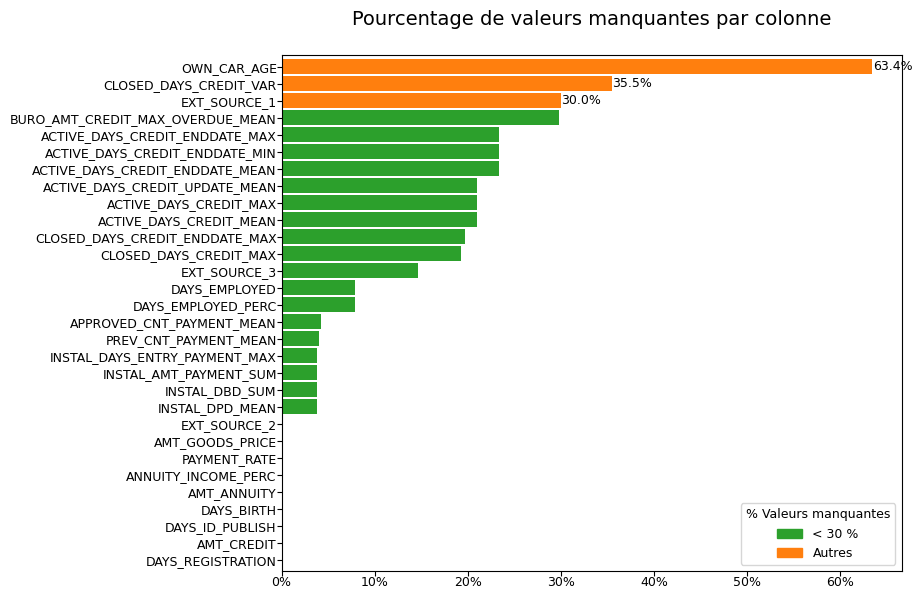

In [260]:
_ = missing_values_barh(train[important_features])

In [270]:
# On enlève ces features car trop de manquants (et pas si grande importance que ça)
del_missing = [
    "OWN_CAR_AGE",
    "ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN",
    "CLOSED_DAYS_CREDIT_VAR",
]
for feature in del_missing:
    if feature in important_features:
        important_features.remove(feature)
len(important_features)

26

corrélations

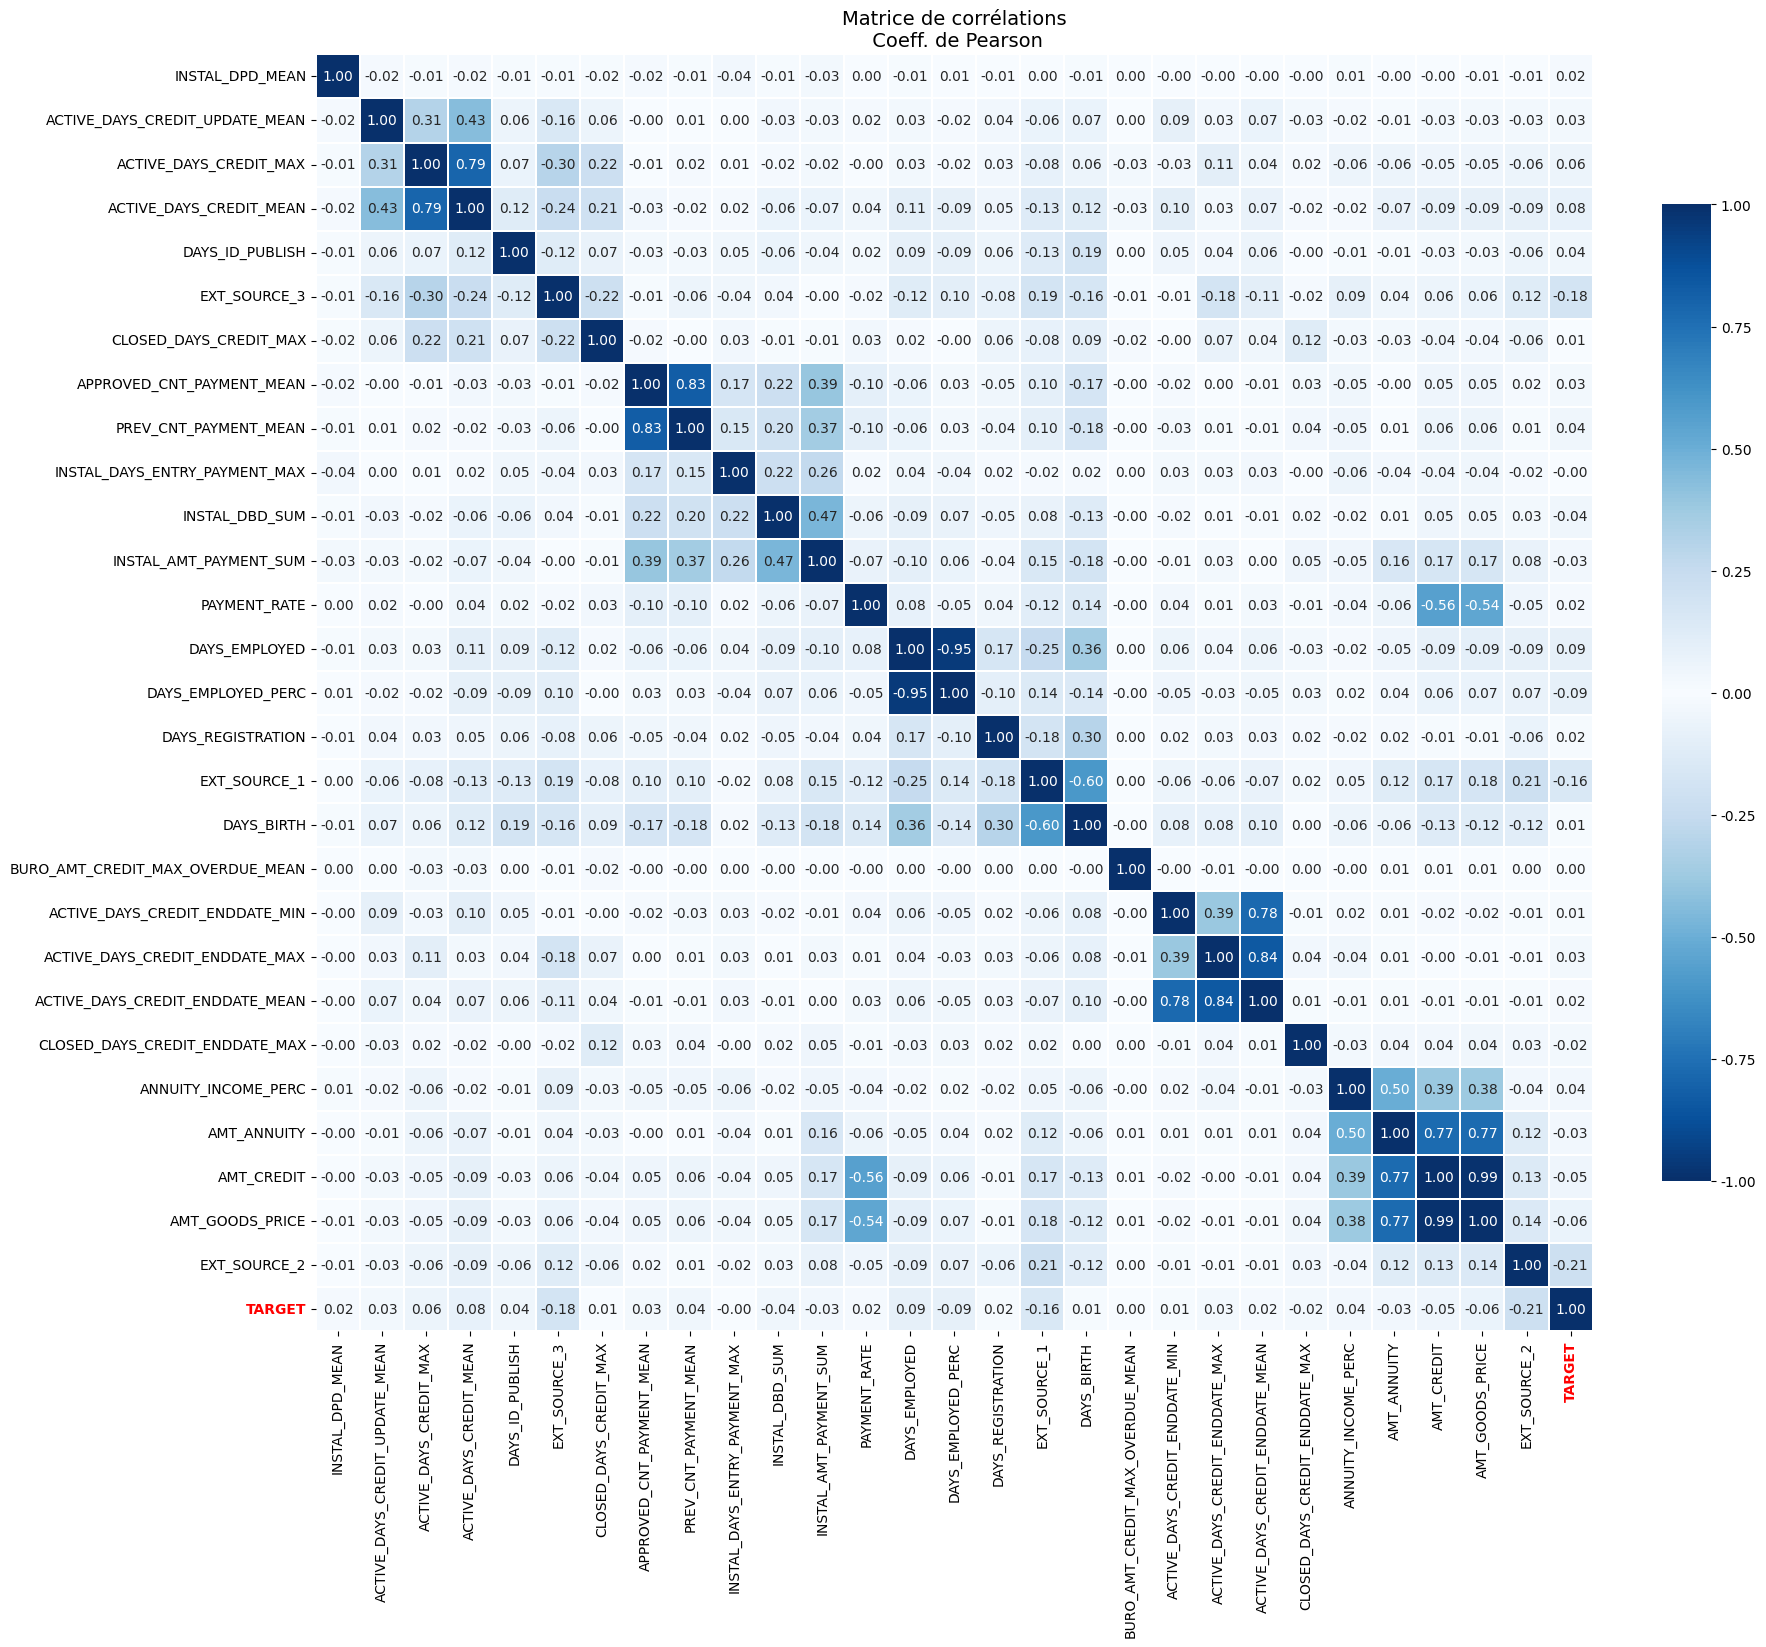

In [263]:
_ = corr_sorted_map(
    train,
    to_process=important_features + ["TARGET"],
    to_mark=["TARGET"],
    method="pearson",
    figsize=(18, 18),
)

In [271]:
# On enlève ces features pour éviter les redondances
del_redondant = [
    "DAYS_EMPLOYED_PERC",
    "ACTIVE_DAYS_CREDIT_ENDDATE_MEAN",
    "ACTIVE_DAYS_CREDIT_MEAN",
    "CLOSED_DAYS_CREDIT_VAR",  # ?
    "DAYS_EMPLOYED_PERC",
]

In [265]:
for feature in del_redondant:
    if feature in important_features:
        important_features.remove(feature)
len(important_features)

26

In [ ]:
important_features

In [298]:
from src.p7_simple_kernel import display_importances

Importance saved in models/light_simple/feature_importance_03.png


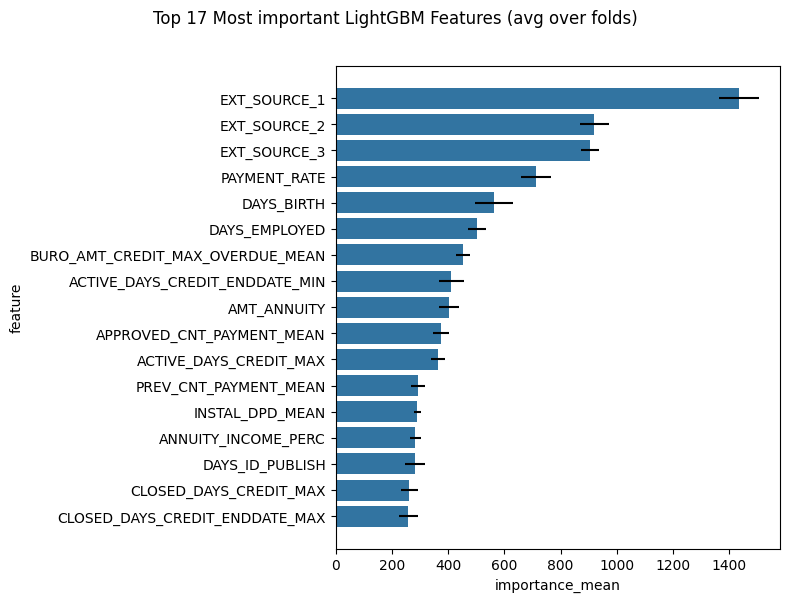

In [299]:
display_importances(
    feat_importance.drop(del_missing + del_redondant, axis=0), top=17, config=config
)

Corrélation sur les features retenues

In [285]:
selected_features = (
    feat_importance.drop(del_missing + del_redondant, axis=0).head(17).index.tolist()
)

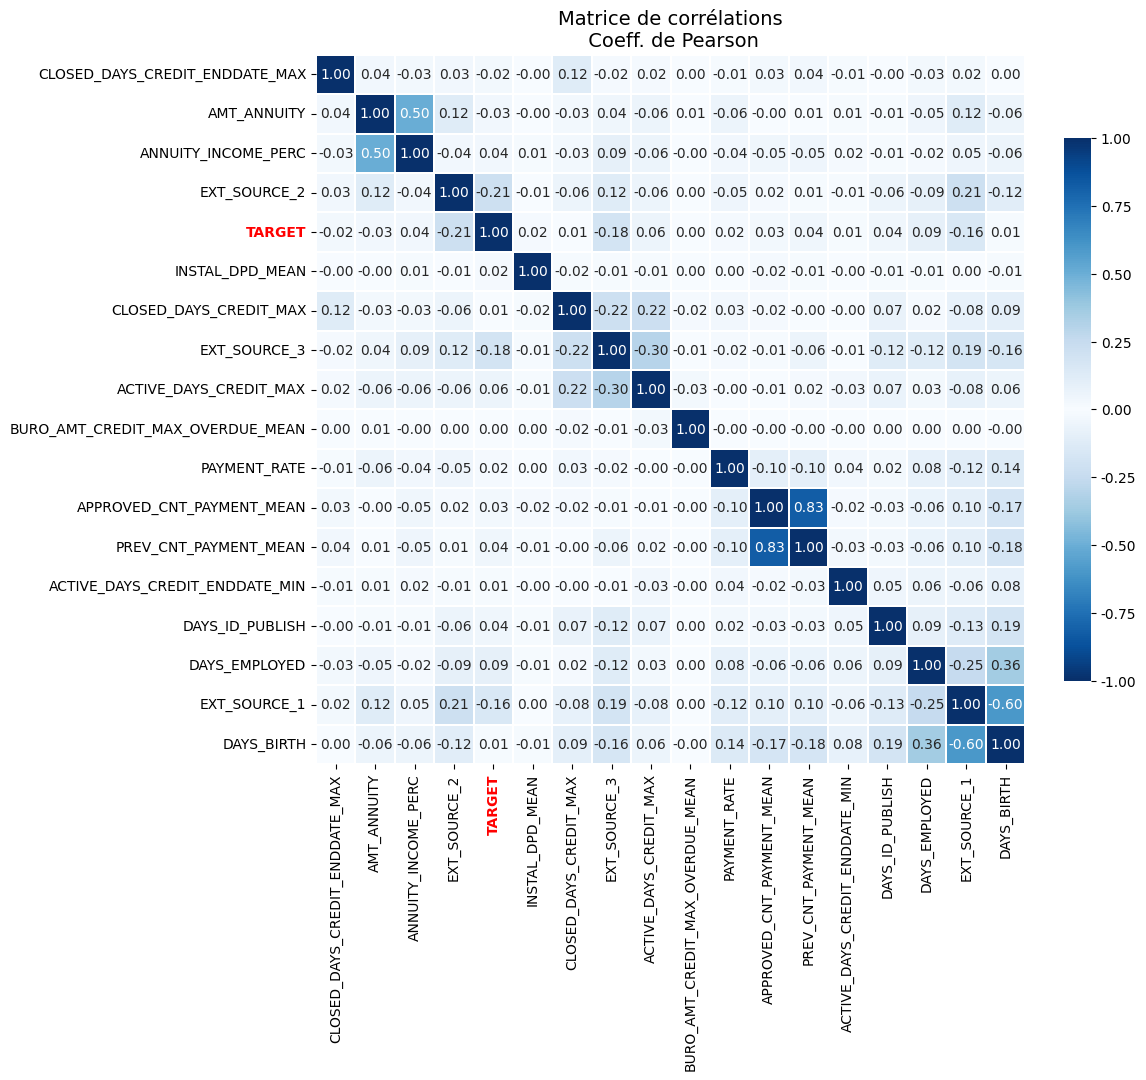

In [286]:
_ = corr_sorted_map(
    train,
    to_process=selected_features + ["TARGET"],
    to_mark=["TARGET"],
    method="pearson",
    figsize=(10, 10),
)

In [300]:
joblib.dump(selected_features, "models/light_simple/selected_features_03.pkl")

['models/light_simple/selected_features_03.pkl']